# Github Dataset的数据分析与处理

## 1. 摘要分析和可视化

### 摘要分析
Github Dataset包含两个csv文件，两个文件中的结构较为相似，因此此处采用较大的文件——repository_data.csv进行分析。首先编写分析数据摘要的函数，如下。其中`calc_5num_abstract()`函数用来计算数值属性的五数概括，`analyze_abstract_github()`用来进行数据摘要的提取，之后`print_abstract()`函数用来在控制台打印分析结果，`save_abstract()`用于将分析结果保存为.csv格式。

In [1]:
import pandas as pd
import numpy as np
import os


def calc_5num_abstract(arr: np.ndarray):
    n_max = np.nanmax(arr)
    n_min = np.nanmin(arr)
    q1 = np.percentile(arr, 25)
    median = np.nanmedian(arr)
    q3 = np.percentile(arr, 75)
    return n_min, q1, median, q3, n_max


def analyze_abstract_github(df: pd.DataFrame) -> dict:
    print("analyzing data")
    analyze_results = {}
    for col in df.columns:
        if df[col].dtype == object:
            count = df[col].value_counts()
            df_meta = {col: count.index, "count": count.values}
            analyze_results[col] = pd.DataFrame(df_meta)
        else:
            values = df[col].values
            mask = np.isnan(values)
            n_min, q1, median, q3, n_max = calc_5num_abstract(values[np.logical_not(mask)])
            null_calc = df[col].isnull().sum()
            res = pd.DataFrame(
                {"min": [n_min], "Q1": [q1], "median": [median], "Q3": [q3], "max": [n_max], "blanks": [null_calc]})
            analyze_results[col] = res
    return analyze_results


def print_abstract(result):
    for k, v in result.items():
        print(k, v.to_string(index=False, max_rows=20), sep="\n")
        print()


def save_abstract(path, result):
    os.makedirs(path, exist_ok=True)
    for k, v in result.items():
        v.to_csv(os.path.join(path, f"{k}.csv"), index=False)

下面的代码用来实现摘要分析。

In [2]:
print("Analyzing repository_data.csv")
df_repository_data = pd.read_csv("data/github/repository_data.csv")
res = analyze_abstract_github(df_repository_data)
result_dir = "result/github/repository_data"
print_abstract(res)
save_abstract(result_dir, res)

Analyzing repository_data.csv
analyzing data
name
                                 name  count
                             dotfiles   5590
                                 blog   2038
                                 docs   1350
                              website   1163
                              scripts    649
                                 core    619
                             examples    615
                            portfolio    579
                                notes    507
                                talks    477
                                  ...    ...
            awesome-harmonica-lessons      1
                        fast-dataview      1
                   Schwarze-Sonne-RAT      1
                       ML-Papers-TLDR      1
                          macports-ci      1
             markdown-to-presentation      1
                        moodle-client      1
                 event-sourcing-graph      1
               react-native-100-Demos      1
MSI-Z

运行结束后，可以在`./result/github/repository_data`目录中找到摘要分析结果。对于标称数据，表格包含两列：可能取值及其频数；对于数值数据，表格中包含6列，分别是`min`（最小值）、`Q1`（第一四分位数）、`median`（中位数）、`Q3`（第三四分位数）、`max`（最大值）、`blanks`（缺失数据个数。

### 数据可视化

下面对repository_data.csv的数据进行可视化，包含直方图、盒图。下面分别对两种图编写可视化函数。

In [3]:
def draw_histogram(df: pd.DataFrame):
    for col in df.columns:
        if df[col].dtype != object:
            df.hist(column=col, bins=100)

def draw_boxgram(df: pd.DataFrame):
    df.boxplot()

直方图

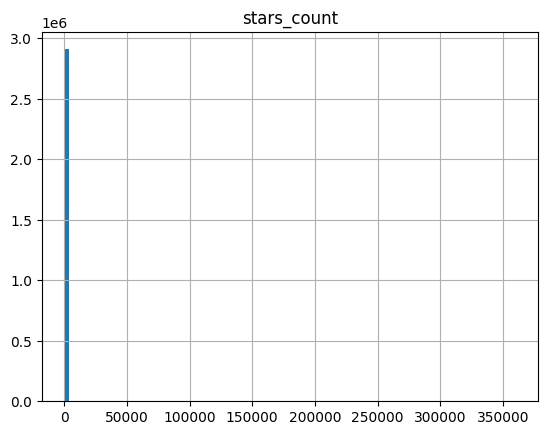

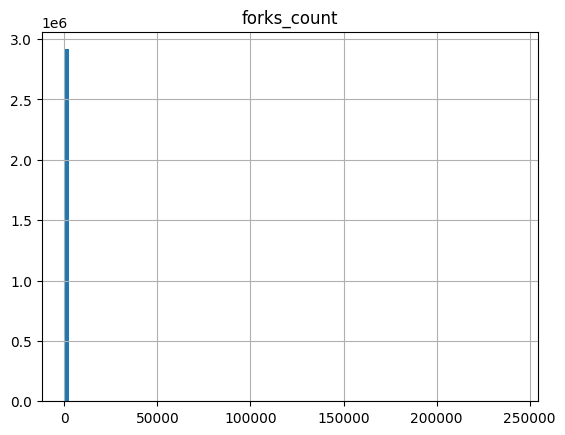

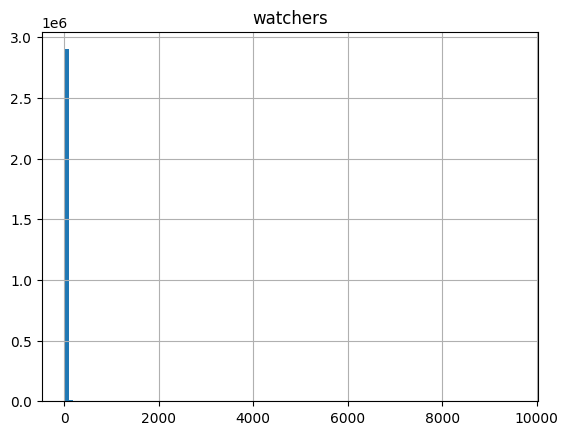

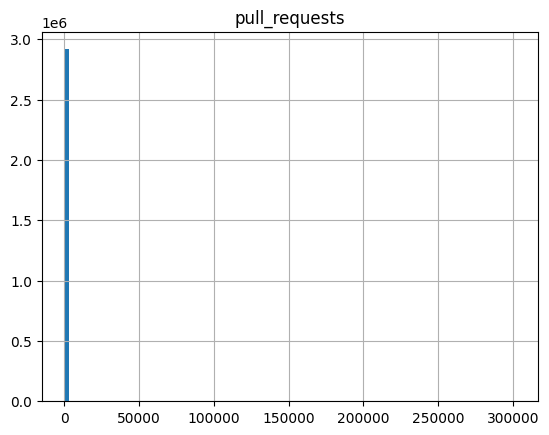

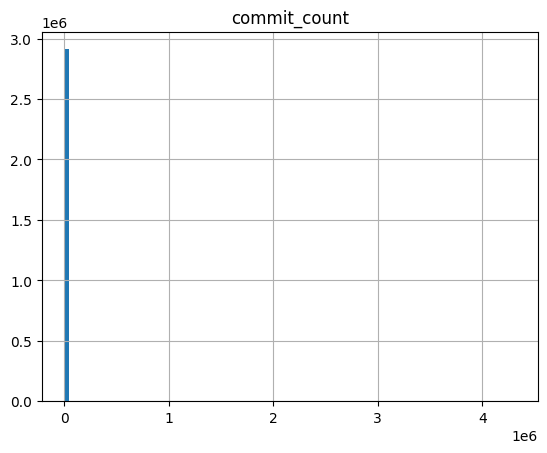

In [4]:
draw_histogram(df_repository_data)

盒图

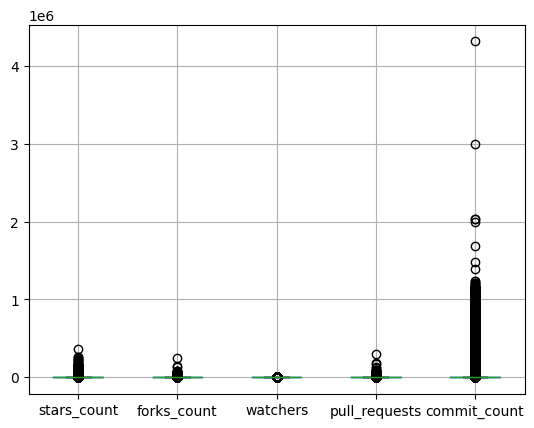

In [5]:
draw_boxgram(df_repository_data)

## 2. 数据缺失处理

从上面的数据分析中可以看出只有commit_count列里存在数据缺失，因此下面的实验仅在此列进行。

首先是缺失数据剔除：

In [6]:
print(len(df_repository_data))

2917951


In [7]:
df = df_repository_data[~df_repository_data["commit_count"].isnull()]
print(len(df))

2916030


该数据减少量与上面分析的结果相符，删除了1921条数据。

第二个是用最高频率值填补缺失值

In [8]:
null_lines = df_repository_data["commit_count"].isnull()
print(df_repository_data[null_lines]["commit_count"])

18104     NaN
31627     NaN
31774     NaN
31906     NaN
31919     NaN
           ..
2916733   NaN
2917040   NaN
2917177   NaN
2917464   NaN
2917641   NaN
Name: commit_count, Length: 1921, dtype: float64


In [9]:
freq_max = df_repository_data["commit_count"].value_counts().index[0]
print(freq_max)

2.0


In [10]:
df = df_repository_data["commit_count"].fillna(freq_max)
print(df[null_lines])

18104      2.0
31627      2.0
31774      2.0
31906      2.0
31919      2.0
          ... 
2916733    2.0
2917040    2.0
2917177    2.0
2917464    2.0
2917641    2.0
Name: commit_count, Length: 1921, dtype: float64


可以看到缺失值均被填充为了2.0（最大频率值）。

下面使用平均数来填充缺失值。

In [11]:
mean = df_repository_data["commit_count"].mean()
print(mean)

614.3709265679709


In [12]:
df = df_repository_data["commit_count"].fillna(mean)
print(df[null_lines])

18104      614.370927
31627      614.370927
31774      614.370927
31906      614.370927
31919      614.370927
              ...    
2916733    614.370927
2917040    614.370927
2917177    614.370927
2917464    614.370927
2917641    614.370927
Name: commit_count, Length: 1921, dtype: float64


空值均被填充为了平均数

下面使用前后值来填充

In [13]:
df = df_repository_data["commit_count"].fillna(method="pad")
print(df[null_lines])

18104      1489.0
31627       561.0
31774       367.0
31906        51.0
31919       160.0
            ...  
2916733       3.0
2917040       4.0
2917177      47.0
2917464       4.0
2917641       8.0
Name: commit_count, Length: 1921, dtype: float64
